<a href="https://colab.research.google.com/github/berdaniera/experiments/blob/master/Airports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Routing problem example

**Scenario:** 10 drop-offs from a common location with 4 airplanes, e.g., following a major event. (Extensions include different pickup and drop-off locations, capacity and time window constraints.)

In [ ]:
!pip install ortools
!pip install geopandas

## Load packages and data

Select random airport locations in the US as our points. Node 0 will be the starting point and all others will be drop-off points.

In [2]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from sklearn.neighbors import DistanceMetric
from math import radians
import pandas as pd
import numpy as np

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [3]:
airports = pd.read_csv("https://ourairports.com/countries/US/airports.csv")

In [44]:
random_air = airports[airports.type == 'small_airport'].sample(10)
random_air['nid'] = range(10)
random_air

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,country_name,iso_country,region_name,iso_region,local_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated,nid
2679,21092,KSNK,small_airport,Winston Field,32.690212,-100.948918,2430.0,NaN,United States,US,Texas,US-TX,TX,Snyder,0,KSNK,SNK,SNK,NaN,NaN,NaN,50,2021-05-11T02:22:15+00:00,0
8559,7946,15MA,small_airport,Canapitsit Airport,41.422298,-70.909500,10.0,NaN,United States,US,Massachusetts,US-MA,MA,Gosnold,0,15MA,NaN,15MA,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,1
13378,18883,K55M,small_airport,Star City Municipal Airport,33.926102,-91.877403,398.0,NaN,United States,US,Arkansas,US-AR,AR,Star City,0,K55M,NaN,55M,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,2
8411,22400,MT01,small_airport,Owen Bros Airport,47.618000,-110.092003,3106.0,NaN,United States,US,Montana,US-MT,MT,Geraldine,0,MT01,NaN,MT01,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,3
3770,14453,7WA5,small_airport,Stuart Island Airpark,48.673379,-123.175439,10.0,NaN,United States,US,Washington,US-WA,WA,Friday Harbor,0,7WA5,SSW,7WA5,NaN,NaN,NaN,50,2020-09-22T18:08:32+00:00,4
11959,14026,79OK,small_airport,Little River Ranch Airport,35.384800,-95.176399,580.0,NaN,United States,US,Oklahoma,US-OK,OK,Pickens,0,79OK,NaN,79OK,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,5
3163,20832,KPHT,small_airport,Henry County Airport,36.338200,-88.382896,580.0,NaN,United States,US,Tennessee,US-TN,TN,Paris,0,KPHT,PHT,PHT,http://www.paristnairport.com/default.htm,https://en.wikipedia.org/wiki/Henry_County_Air...,NaN,50,2014-09-06T10:50:46+00:00,6
10410,24668,SN92,small_airport,Sunshine Ranch Airport,39.333302,-96.700302,1300.0,NaN,United States,US,Kansas,US-KS,KS,Manhattan,0,SN92,NaN,SN92,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,7
5575,23878,OR28,small_airport,Harvey's Acres Airport,45.439328,-122.890283,250.0,NaN,United States,US,Oregon,US-OR,OR,Beaverton,0,OR28,NaN,OR28,NaN,NaN,NaN,50,2021-04-15T17:47:35+00:00,8
7893,15314,91LA,small_airport,Koch Airport,30.534599,-92.367401,51.0,NaN,United States,US,Louisiana,US-LA,LA,Eunice,0,91LA,NaN,91LA,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,9


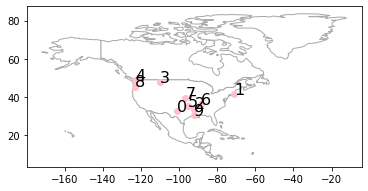

In [45]:
# plot map
gdf = gpd.GeoDataFrame(random_air, 
                       geometry=gpd.points_from_xy(random_air.longitude_deg, random_air.latitude_deg))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(color='white', edgecolor='darkgrey')
for x, y, label in zip(random_air.longitude_deg, random_air.latitude_deg, random_air.nid):
    ax.annotate(label, xy=(x, y), xytext=(0, 0), fontsize=16, textcoords="offset points")
gdf.plot(ax=ax, color='pink')

In [46]:
# Generate data for analysis
# get Haversine distance between each point in km
random_air['latitude_rad'] = np.radians(random_air['latitude_deg'])
random_air['longitude_rad'] = np.radians(random_air['longitude_deg'])
dist = DistanceMetric.get_metric('haversine')
air_coords = random_air[['latitude_rad','longitude_rad']].to_numpy()
distance_km = dist.pairwise(air_coords)*6373 # km distance

data = {}
data['distance_matrix'] = np.ndarray.tolist(distance_km.astype(np.int))
data['num_vehicles'] = 4
data['depot'] = 0 # this is the starting/ending depot

# maximum travel distance
maxdist = int(max(5000, np.amax(distance_km)*2.1))

print(distance_km.astype(np.int))
# distance between each point

[[   0 2820  854 1830 2565  610 1219  831 2353  847]
 [2820    0 2018 3147 4102 2210 1611 2189 4148 2269]
 [ 854 2018    0 2151 3054  342  415  739 2922  380]
 [1830 3147 2151    0  976 1836 2177 1416 1007 2427]
 [2565 4102 3054  976    0 2721 3129 2342  360 3285]
 [ 610 2210  342 1836 2721    0  621  459 2582  599]
 [1219 1611  415 2177 3129  621    0  802 3045  743]
 [ 831 2189  739 1416 2342  459  802    0 2244 1055]
 [2353 4148 2922 1007  360 2582 3045 2244    0 3119]
 [ 847 2269  380 2427 3285  599  743 1055 3119    0]]


Functions and parameters based on https://developers.google.com/optimization/routing/vrp

In [16]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        print(plan_output)

Optimization parameters

In [47]:
# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Optimization parameters -- we're solving for the cumulative distance
dimension_name = 'Distance'
routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        maxdist,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [48]:
# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    print_solution(data, manager, routing, solution)
else:
    print('No solution found !')


Objective: 578434
Route for vehicle 0:
 0 ->  7 ->  6 ->  2 ->  9 -> 0
Distance of the route: 3275km

Route for vehicle 1:
 0 -> 0
Distance of the route: 0km

Route for vehicle 2:
 0 ->  5 ->  1 -> 0
Distance of the route: 5640km

Route for vehicle 3:
 0 ->  3 ->  4 ->  8 -> 0
Distance of the route: 5519km



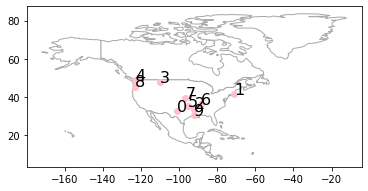

In [49]:
# plot the map again
gdf = gpd.GeoDataFrame(random_air, 
                       geometry=gpd.points_from_xy(random_air.longitude_deg, random_air.latitude_deg))

ax = world[world.continent == 'North America'].plot(color='white', edgecolor='darkgrey')
for x, y, label in zip(random_air.longitude_deg, random_air.latitude_deg, random_air.nid):
    ax.annotate(label, xy=(x, y), xytext=(0, 0), fontsize=16, textcoords="offset points")
gdf.plot(ax=ax, color='pink')

# Conclusion

Only three airplanes are needed for these routes:
*   one plane takes the long trip to point 1, stopping at point 5 on the way, 
*   another covers the central stops, and 
*   the third goes on a route to the northwest.

Additional extensions would include trips with a mix of pickups and drop-offs.